In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from gpt import GPT
import matplotlib.pyplot as plt

In [2]:
with open("text.txt", "r", encoding="utf-8") as file:
    text = file.read()

In [3]:
SEED = 4242
VOCAB = sorted(list(set(text.split(" "))))
VOCAB_SIZE = len(VOCAB)
N_SAMPLES = 320000
BATCH_SIZE = 64
SEQ_SIZE = 256
HEADS_AMT = 8
LAYERS_AMT = 3
D_MODEL = 512
D_QUERY = 64
D_KEY = 64
D_VALUE = 64
D_FEED_FORWARD = 2048
DROPOUT = 0.2
TEST_SIZE = 0.1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 0.001

In [4]:
stoi = {token: idx for idx, token in enumerate(VOCAB)}
itos = {idx: token for idx, token in enumerate(VOCAB)}
encode = lambda sequence: [stoi[token] for token in sequence.split(" ")]
decode = lambda idxs: " ".join([itos[idx] for idx in idxs])

In [5]:
data = encode(text)

In [6]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

X, y = [], []

idxs = torch.randint(0, len(data) - SEQ_SIZE, (N_SAMPLES,))

for idx in idxs:
    X.append(data[idx:idx+SEQ_SIZE])
    y.append(data[idx+1:idx+SEQ_SIZE+1])

In [7]:
dataset = TensorDataset(torch.tensor(X, dtype=torch.long),
                        torch.tensor(y, dtype=torch.long))

In [8]:
dataloader = DataLoader(dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True)

In [9]:
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

model = GPT(
    vocab_size=VOCAB_SIZE,
    seq_size=SEQ_SIZE,
    heads_amt=HEADS_AMT,
    layers_amt=LAYERS_AMT,
    d_model=D_MODEL,
    d_query=D_QUERY,
    d_key=D_KEY,
    d_value=D_VALUE,
    d_feed_forward=D_FEED_FORWARD,
    dropout=DROPOUT
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(),
                              lr=LEARNING_RATE)

In [11]:
batch = []
train_losses = []
test_losses = []


model = model.to(DEVICE)

for i, (X, y) in enumerate(dataloader):

  X, y = X.to(DEVICE), y.to(DEVICE)

  if (i + 1) % 100 == 0:

    model.eval()

    with torch.inference_mode():

      logits = model(X)

      S, T, V = logits.shape

      logits = logits.view(S * T, V)

      y = y.view(S * T)

      test_loss = criterion(logits, y)

      print(f"Batch: {i + 1}\n----------")
      print(f"Train loss: {train_loss.item():.5f}")
      print(f"Test loss: {test_loss.item():.5f}\n")

      batch.append(i + 1)
      train_losses.append(train_loss.item())
      test_losses.append(test_loss.item())

  else:

    model.train()

    logits = model(X)

    S, T, V = logits.shape

    logits = logits.view(S * T, V)

    y = y.view(S * T)

    train_loss = criterion(logits, y)

    optimizer.zero_grad(set_to_none=True)

    train_loss.backward()

    optimizer.step()

Batch: 100
----------
Train loss: 4.08003
Test loss: 4.13557

Batch: 200
----------
Train loss: 1.63941
Test loss: 1.36169

Batch: 300
----------
Train loss: 0.19787
Test loss: 0.12356

Batch: 400
----------
Train loss: 0.11665
Test loss: 0.08227

Batch: 500
----------
Train loss: 0.08662
Test loss: 0.07339

Batch: 600
----------
Train loss: 0.07306
Test loss: 0.05580

Batch: 700
----------
Train loss: 0.06464
Test loss: 0.05112

Batch: 800
----------
Train loss: 0.06357
Test loss: 0.04759

Batch: 900
----------
Train loss: 0.05137
Test loss: 0.04882

Batch: 1000
----------
Train loss: 0.05602
Test loss: 0.04626

Batch: 1100
----------
Train loss: 0.04832
Test loss: 0.04396

Batch: 1200
----------
Train loss: 0.04665
Test loss: 0.04517

Batch: 1300
----------
Train loss: 0.04595
Test loss: 0.04379

Batch: 1400
----------
Train loss: 0.05603
Test loss: 0.03721

Batch: 1500
----------
Train loss: 0.04277
Test loss: 0.03707

Batch: 1600
----------
Train loss: 0.04952
Test loss: 0.03838

B

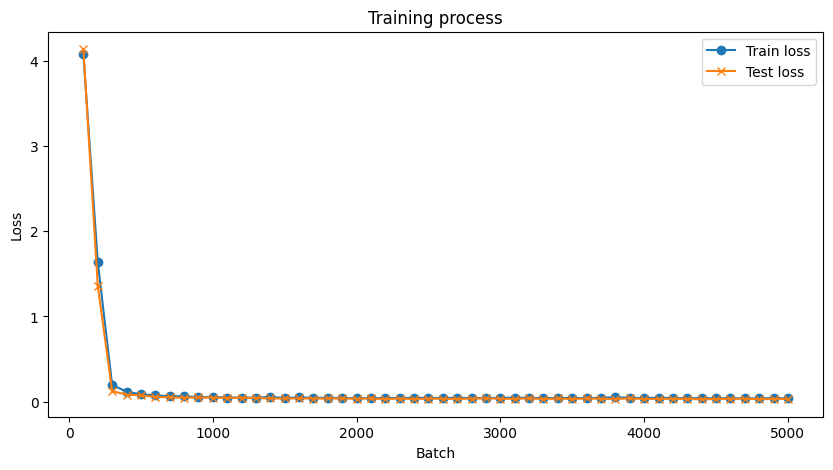

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(batch, train_losses, label="Train loss", marker="o")
plt.plot(batch, test_losses, label="Test loss", marker="x")
plt.title("Training process")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [13]:
context = "гаррі сказав герміоні щоб вона швидко зачинила двері які врятували їх від"

context = torch.tensor([encode(context)], dtype=torch.long, device=DEVICE)

answer = decode(model.generate(context, tokens_amt=100)[0].tolist())

print(answer)

гаррі сказав герміоні щоб вона швидко зачинила двері які врятували їх від темних мистецтв прошепотіла герміона вони мали вже двох учителів захисту від темних мистецтв щороку нового ходили чутки що ця посада приносить нещастя ой не знаю чи він потягне засумнівався рон схоже що його можна прикінчити будьяким закляттям о вибач повернувся він до гаррі що ти хотів нам сказати гаррі розповів про суперечку між містером і місіс візлі та про попередження містера візлі рон був приголомшений а герміона притисла руки до вуст нарешті вона їх опустила й промовила отже сіріус блек утік щоб полювати за тобою ой гаррі тобі треба бути дужедуже обережним і не шукати собі нових пригод та я


In [14]:
torch.save(model.state_dict(), "model.pth")

In [15]:
print(f"Total Trainable Params: {sum(params.numel() for params in model.parameters() if params.requires_grad)}")

Total Trainable Params: 26320969
